In [118]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [119]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [120]:
len(words)

32033

In [121]:
chars = sorted(list(set(''.join(words))))
stoi = { ch:i+1 for i,ch in enumerate(chars) }
stoi['.'] = 0
itos = { i:ch for ch,i in stoi.items() }
vocab_size = len(stoi)
print(vocab_size)
print(stoi) 
print(itos)

27
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [122]:
block_size = 3

def build_dataset(words):
    xs = []
    ys = []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            xs.append(context)
            ys.append(ix)
            context = context[1:] + [ix]
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys

import random
random.seed(42)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

print(Xtr.shape, Ytr.shape)
print(Xdev.shape, Ydev.shape)
print(Xte.shape, Yte.shape)


torch.Size([182778, 3]) torch.Size([182778])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


In [168]:
print(Xtr[:10])
print(Ytr[:10])

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22]])
tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9])


In [171]:
n_embd = 10 # Dimensionality of embedding space
n_hidden = 200 # Number of neurons in the hidden layer.

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
# b1 = torch.randn((n_hidden), generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn((vocab_size), generator=g) * 0

# BatchNorm parameters that are initialized such that at least at initialization,
# the output of the preactivation function (aka linear transform + bias) is unit Gaussian.
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnstdev_running = torch.ones((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))

# parameters = [C, W1, b1, W2, b2, bngain, bnbias]
parameters = [C, W1, W2, b2, bngain, bnbias]
# parameters = [C, W1, b1, W2, b2] 
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

KeyboardInterrupt: 

tensor(0.0158) tensor(1.0092) tensor(1.0184)
tensor(0.0100) tensor(1.0458) tensor(1.0938)
tensor(0.0066) tensor(3.3399) tensor(11.1551)


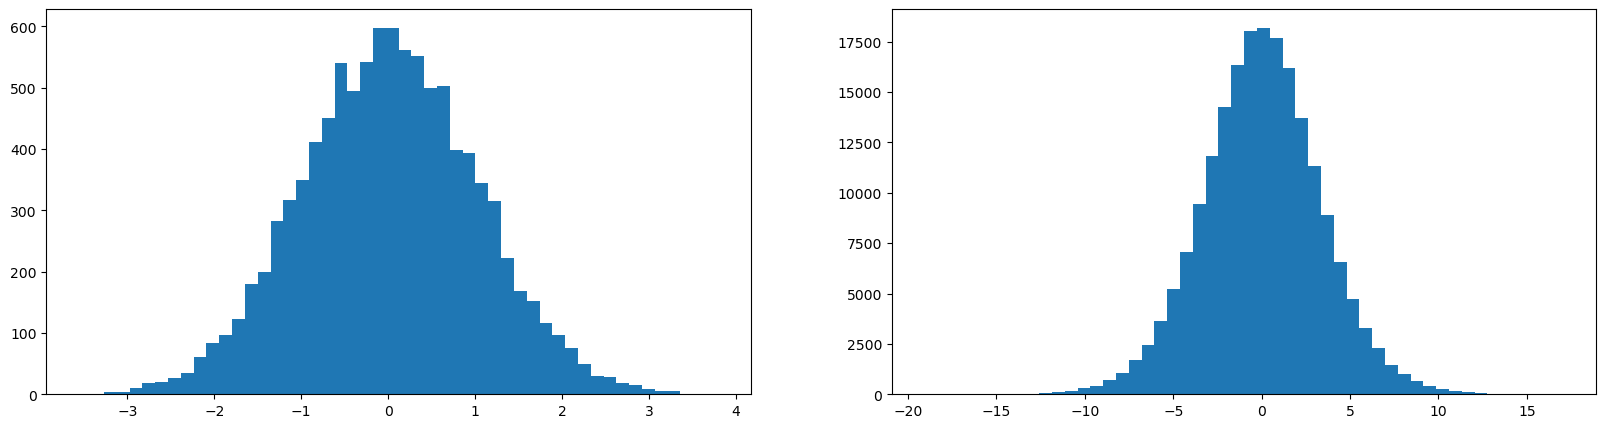

In [124]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std(), x.var())
print(w.mean(), w.std(), w.var())
print(y.mean(), y.std(), y.var())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), bins=50);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), bins=50);

In [ ]:
batch_size = 32
max_steps = 200000
lossi = []
momentum = 0.001

for i in range(max_steps):
    # Sample a batch of data
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward Pass
    emb = C[Xb]
    embcat = emb.view(batch_size, -1)
    hpreact = embcat @ W1 #+ b1
    bnstdevi = hpreact.std(dim=0, keepdim=True)
    bnmeani = hpreact.mean(dim=0, keepdim=True)
    hpreact = bngain * ((hpreact - bnmeani) / bnstdevi) + bnbias

    with torch.no_grad():
        bnstdev_running = bnstdev_running * (1 - momentum) + bnstdevi * momentum
        bnmean_running = bnmean_running * (1 - momentum) + bnmeani * momentum

    h = hpreact.tanh()
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # Track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # break

# Note 1: on the 0th iteration, the loss is 30.    

      0/ 200000: 3.3442
  10000/ 200000: 2.1095
  20000/ 200000: 1.9760
  30000/ 200000: 1.7753
  40000/ 200000: 2.0790
  50000/ 200000: 1.9369
  60000/ 200000: 2.5229
  70000/ 200000: 2.4514
  80000/ 200000: 1.7932
  90000/ 200000: 2.2978
 100000/ 200000: 2.1749
 110000/ 200000: 2.0796
 120000/ 200000: 1.9102
 130000/ 200000: 1.9998
 140000/ 200000: 2.1022
 150000/ 200000: 2.3006
 160000/ 200000: 1.9463
 170000/ 200000: 2.1586
 180000/ 200000: 2.1738
 190000/ 200000: 1.7376


In [ ]:
hpreact.shape

torch.Size([32, 200])

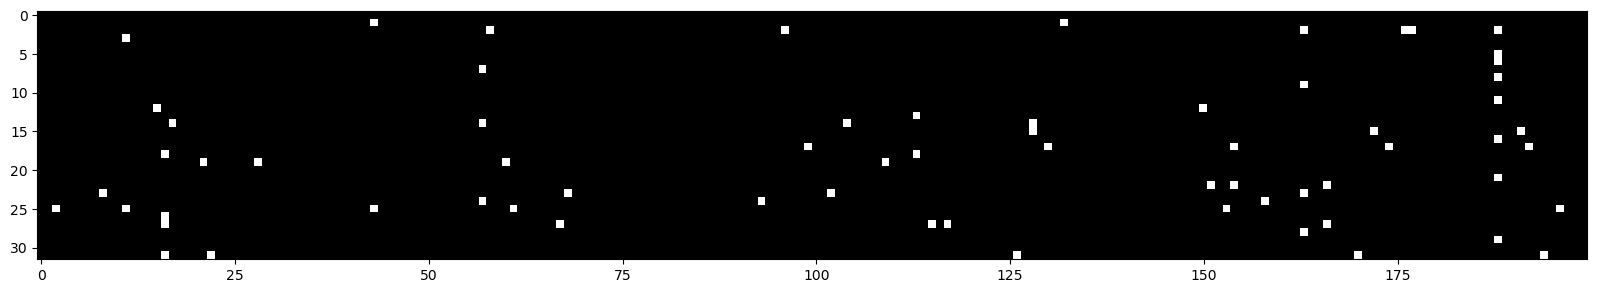

In [ ]:
h.abs().shape
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')


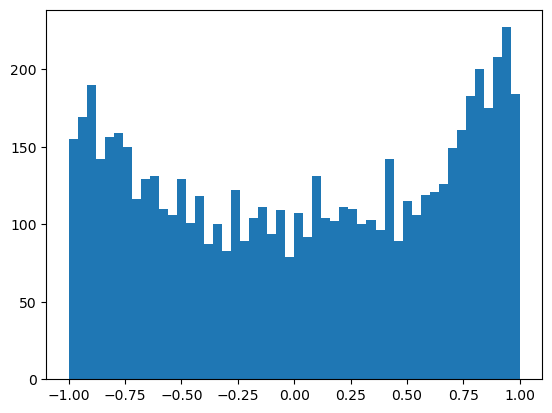

In [ ]:
plt.hist(h.view(-1).tolist(), bins=50);

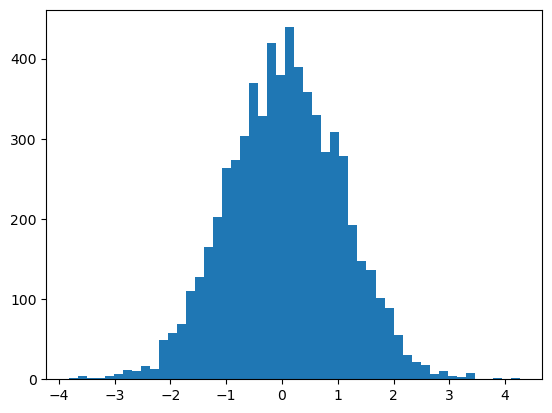

In [ ]:
plt.hist(hpreact.view(-1).tolist(), bins=50);

In [ ]:
sample_logits = torch.tensor([0.0, 5.0, 0.0, 0.0])
sample_probs = F.softmax(sample_logits, dim=0)
sample_probs = -sample_probs[2].log()
sample_probs

random_tensor = torch.randn(4)
random_tensor

tensor([ 0.7235,  1.8367, -0.2537,  0.4349])

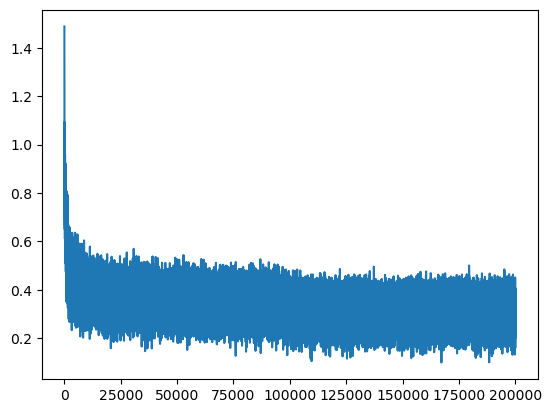

In [ ]:
plt.plot(lossi)

In [162]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(dim=0, keepdim=True)
    bnstdev = hpreact.std(dim=0, keepdim=True)

In [163]:
print(bnmean[:, :10])
print(bnmean_running[:, :10])

tensor([[-1.7137,  0.6245, -1.7781,  0.4022,  1.4183,  0.9603,  1.2618, -0.4461,
          0.9268,  1.5451]])
tensor([[-1.7137,  0.6328, -1.7860,  0.4047,  1.3970,  0.9512,  1.2711, -0.4557,
          0.9464,  1.5602]])


In [165]:
@torch.no_grad()
def split_loss(split):
    x,y = {
            'train': (Xtr, Ytr),
            'dev': (Xdev, Ydev),
            'test': (Xte, Yte),
            }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    hpreact = bngain * ((hpreact - bnmean_running) / bnstdev_running) + bnbias 
    h = hpreact.tanh()
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split}: {loss.item():.4f}')

split_loss('train')
split_loss('dev')

train: 2.0182
dev: 2.3215


In [170]:
g = torch.Generator().manual_seed(2147483647 + 10)

print(itos)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(1, -1)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * ((hpreact - bnmean_running) / bnstdev_running) + bnbias 
        # print(hpreact)
        # print(hpreact.mean(dim=0, keepdim=True))
        # print(hpreact.std(dim=0, keepdim=True))
        # print(bngain, bnbias)
        # hpreact = bngain * ((hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True)) + bnbias 
        # print(hpreact)
        h = hpreact.tanh()
        # print(h)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # print(probs)
        # print(probs)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))



{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
mona.
mayah.
see.
mad.
ryah.
remmadiendra.
grace.
korelin.
shi.
jenne.
elieana.
arleigh.
malaia.
nosadhergihiriel.
kendreth.
kourterian.
brence.
ryyah.
faeh.
yuma.
